In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from astropy.constants import c
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astroquery.simbad import Simbad



In [2]:
from astroquery.irsa_dust import IrsaDust

## Read BlackCAT and preprocess

In [ ]:
data_dir = "/epyc/data/"

bc = pd.read_csv('../data/BlackCATscrape.csv')

In [3]:
fx_mean = bc['fxpeak\n[2-10] keV\n[erg s-1 cm-2]'].mean() * u.erg / u.s / u.cm ** 2

In [4]:
(fx_mean.to(u.erg / u.s / u.cm**2) * 4 * np.pi * (4 * u.kpc) ** 2).to(u.erg/u.s)

<Quantity 1.50366195e+38 erg / s>

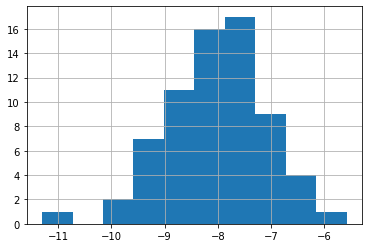

In [5]:
np.log10(bc['fxpeak\n[2-10] keV\n[erg s-1 cm-2]']).hist()

### extract distance and magnitudes out of data format
ignore lower and upper limits

In [8]:
def extract_distance(d_str):
    d_err = np.nan
    if str(d_str) == 'nan':
        return [np.nan] * 2
    if '/' in d_str:
        return [np.nan] * 2
    if '±' in d_str:
        d, d_err = d_str.split('±')
        if '-' in d_err:
            d_err = np.mean([float(x) for x in d_str.split('-')])
        d_err = float(d_err)
        if '∼' in d:
            d = d[1:]
    elif '∼' in d_str:
        sep = d_str[1:]
        if '±' in sep[0]:
            d, d_err = sep[1].split('±')
            d_err = float(d_err)
        else:
            # import pdb; pdb.set_trace()
            d = sep[0]
    elif '+' in d_str:
        sep = d_str.split('+')
        d = sep[0]
        if '-' in sep[1]:
            d_err = np.mean([float(x) for x in sep[1].split('-')])
    elif '-' in d_str:
        ds = [float(x) for x in d_str.split('-')]
        d = np.mean(ds)
        d_err = (ds[1] - ds[0]) / 2
    elif '≥' in d_str:
        return [np.nan] * 2
    elif '>' in d_str:
        return [np.nan] * 2
    elif '<' in d_str:
        return [np.nan] * 2
    return float(d), d_err
    

In [9]:
test = [extract_distance(d) for d in bc['d \n[kpc]']]
d = pd.DataFrame(test, columns = ['d', 'd_err'])

In [10]:
def extract_band_mag(mag_str):
    mag_err = np.nan
    if str(mag_str) == 'nan':
        return [np.nan] * 3
    if '=' in mag_str:
        sep = mag_str.split('=')
        band = sep[0]
        if '±' in sep[1]:
            mag, mag_err = sep[1].split('±')
            mag_err = float(mag_err)
        else:
            mag = sep[1]
    elif '∼' in mag_str:
        sep = mag_str.split('∼')
        band = sep[0]
        if '±' in sep[1]:
            mag, mag_err = sep[1].split('±')
            mag_err = float(mag_err)
        else:
            mag = sep[1]
    elif '>' in mag_str:
        return [np.nan] * 3
    elif '≥' in mag_str:
        return [np.nan] * 3
    elif '<' in mag_str:
        return [np.nan] * 3
    return band, float(mag), mag_err
    

In [11]:
test = [extract_band_mag(mag) for mag in bc['Magnitude\nOutburst (AB)']]
ob = pd.DataFrame(test, columns = ['ob_band', 'ob_mag', 'ob_mag_err'])

In [12]:
test = [extract_band_mag(mag) for mag in bc['Mag. \nQuies. (AB)']]
q = pd.DataFrame(test, columns = ['q_band', 'q_mag', 'q_mag_err'])

In [13]:
for col in d.columns:
    bc[col] = d[col]
for col in ob.columns:
    bc[col] = ob[col]
for col in q.columns:
    bc[col] = q[col]

# Compute Luminosity of sources

### drop to subset with measured distances

In [14]:
df = bc.dropna(subset=['d'])

In [15]:
len(df)

32

### Calculate peak luminosity

In [16]:
Lx = df['fxpeak\n[2-10] keV\n[erg s-1 cm-2]'].values * ((df['d'].values * u.kpc)**2).to(u.cm**2).value * 4 * np.pi

In [ ]:
df['Lx'] = df['fxpeak\n[2-10] keV\n[erg s-1 cm-2]'] * 4 * np.pi * (df['d'] * u.kpc.to(u.cm)) ** 2

(array([2., 0., 1., 1., 5., 4., 5., 5., 5., 4.]),
 array([35.11133471, 35.51056158, 35.90978845, 36.30901532, 36.70824219,
        37.10746906, 37.50669593, 37.9059228 , 38.30514967, 38.70437654,
        39.10360342]),
 <a list of 10 Patch objects>)

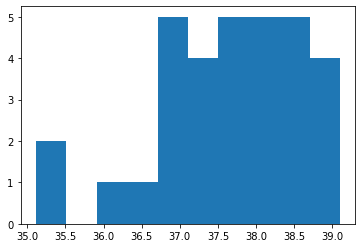

In [17]:
plt.hist(np.log10(Lx))

### Look at distribution of OIR bands

In [18]:
df['ob_band'].value_counts()

V             12
R              5
I              3
J              2
i’             1
v              1
g'             1
Ks             1
H              1
B              1
K (not AB)     1
Name: ob_band, dtype: int64

In [19]:
df['Name'] = df['Name \n(Counterpart)'].str.split('\n').str[0].str.strip()

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Use irsa to get extinction at observed band and position

In [20]:
width = {'V': 107.3, }

def get_filter_name(band):
    filters = ['CTIO U', 'CTIO B', 'CTIO V', 'CTIO R', 'CTIO I', 'DSS-II g',
       'DSS-II r', 'DSS-II i', 'SDSS u', 'SDSS g', 'SDSS r', 'SDSS i',
       'SDSS z', 'UKIRT J', 'UKIRT H', 'UKIRT K', '2MASS J', '2MASS H',
       '2MASS Ks', 'IRAC-1', 'IRAC-2', 'IRAC-3', 'IRAC-4', 'WISE-1',
       'WISE-2']
    if str(band) == 'nan':
        return np.nan
    if band == 'Ks':
        return '2MASS Ks'
    else:
        for f in filters:
            if band[0] == f[-1]:
                return f

In [21]:
df['ob_filter'] = [get_filter_name(b) for b in df['ob_band']]

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
df['q_filter'] = [get_filter_name(b) for b in df['q_band']]

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### avg diff between outburst and quiescent magnitudes
excludes upper limits so this is probably underestimated

In [24]:
(ob['ob_mag'] - q['q_mag']).dropna().mean()

-4.736071428571429

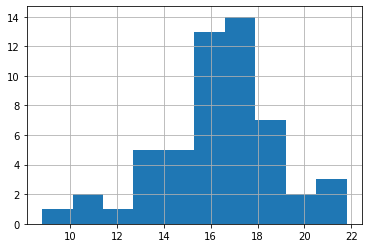

In [25]:
ob['ob_mag'].hist()

### Query for extinctions and correct magitudes

Also calculate OIR luminosities???

In [26]:
ext_corr_mag_ob = []
central_ll = []
L_opt = []
del_ll = 100 * u.nm
for obj in df['Name']:
    print(obj)
    table = IrsaDust.get_extinction_table(obj)
    table = table.to_pandas().set_index('Filter_name')
    
    f = df.query(f'Name== "{obj}"')['ob_filter'].iloc[0]
    d = df.query(f'Name== "{obj}"')['d'].iloc[0]    
    if not pd.isna(f):
        ll, A_AV, _, __, A = table.loc[f]
        central_ll.append(ll * 1000)
        mag = df.query(f'Name== "{obj}"')['ob_mag'].iloc[0] - A
        L = ((mag * u.ABmag).to(u.Jy) * \
             4 * np.pi *  (d * u.kpc) **2 * \
             (c * del_ll / (ll * u.um) ** 2)
            ).to(u.erg/u.s) 
        ext_corr_mag_ob.append(mag)
        L_opt.append(L.value)
        
    else:
        central_ll.append(np.nan)
        ext_corr_mag_ob.append(np.nan)
        L_opt.append(np.nan)
    
    

MAXI J1305-704
MAXI J1836-194
MAXI J1659-152
XTE J1752-223
XTE J1817-330
XTE J1818-245
Swift J1753.5-0127
IGR J17098-3628
XTE J1720-318
XTE J1908+094
XTE J1650-500
XTE J1118+480
XTE J1859+226
SAX J1819.3-2525
XTE J1550-564
GRS 1739-278
GRO J1655-40
GRS 1716-249
GRS 1009-45
GRS 1915+105
GRO J0422+32
GRS 1124-684
GS 2023+338
GS 2000+251
GS 1354-64
EXO 1846-031
H 1705-250
H 1743-322
3A 0620-003
4U 1755-338
4U 1543-475
4U 1630-472


In [27]:
df['Lx'] = Lx
df['L_opt'] = L_opt

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
df['corr_mag'] = ext_corr_mag_ob

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
data = df.dropna(subset = ['L_opt'])

In [30]:
len(data)

28

### X-ray vs OIR luminosity

In [ ]:
data.loc[data['ob_band'] == 'V'].plot.scatter(x='ob_mag', y='fxpeak\n[2-10] keV\n[erg s-1 cm-2]', color='plot_color', ax=ax)


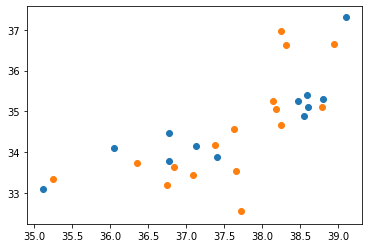

In [75]:
plt.scatter(np.log10(data[data['ob_band'] == 'V']['Lx']), np.log10(data[data['ob_band'] == 'V']['L_opt']))
plt.scatter(np.log10(data[~(data['ob_band'] == 'V')]['Lx']), np.log10(data[~(data['ob_band'] == 'V')]['L_opt']))

### Use GMM to generate more data

In [34]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from astroML.utils import convert_2D_cov
from astroML.plotting.tools import draw_ellipse

X = np.array([np.log10(data['Lx']), np.log10(data['L_opt'])]).T



/epyc/opt/anaconda/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/epyc/opt/anaconda/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


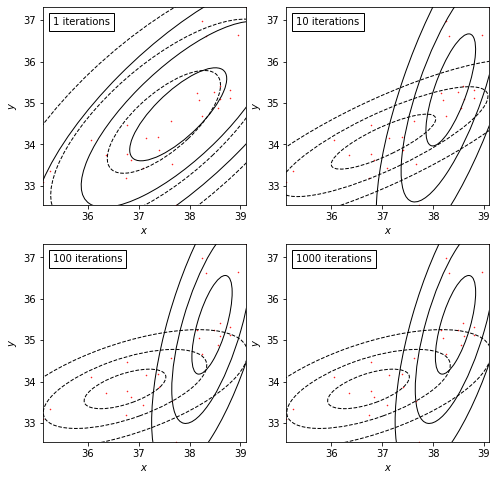

In [35]:
#------------------------------------------------------------
# Compute and plot the results
fig = plt.figure(figsize=(8, 8))

def plot_gmm_solution(ax, clf, iterations):  
    ax.plot(X[:, 0], X[:, 1], '.', c='red', ms=1, zorder=1)
    ax.set_xlim(X[:,0].min(), X[:,0].max())
    ax.set_ylim(X[:,1].min(), X[:,1].max())
    ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    
    for i in range(clf.n_components):
        mean = clf.means_[i]
        cov = clf.covariances_[i]
        if cov.ndim == 1:
            cov = np.diag(cov)
        draw_ellipse(mean, cov, ax=ax, fc='none', ec='k',ls=linestyles[i], zorder=2)
    
    ax.text(0.05, 0.95, "%i iterations" % iterations,
        ha='left', va='top', transform=ax.transAxes,
        bbox=dict(fc='w', ec='k'))

 
linestyles = ['-', '--', ':']
np.random.seed(1)
#plot solutions as a function of iteration
def fitAndPlot(X, n_components=1, n_iter=100):
    
    for i,iter in enumerate(np.logspace(0, np.log10(n_iter), 4, dtype=int)):
        clf = GaussianMixture(n_components, random_state=np.random.seed(1), 
                              max_iter=iter, init_params='random').fit(X)

        ax = fig.add_subplot(2,2,i+1)
        plot_gmm_solution(ax, clf, iter)
    return clf
  
clf = fitAndPlot(X, n_components=2, n_iter=1000)

### Apply this to simulations

In [36]:
sim = pd.read_csv('../data/sample_xrb_positions_10M.csv.gz', header=None, names=['ra', 'dec', 'd_kpc', 'E(B-V)'])

In [37]:
R_V = 3.1
sim['distmod'] = 5 * np.log10(sim["d_kpc"] * 1.e3) - 5.0  # Calculate distance modulus for all XRB
sim['A_V'] = R_V * sim['E(B-V)']   # Calculate extinction  https://ned.ipac.caltech.edu/level5/Sept07/Li2/Li2.html
sim['nH'] = 2.21 * 10 ** 21 * sim['A_V']   # column density in cm ** -2 https://arxiv.org/pdf/0903.2057.pdf

In [38]:
new_X, _ = clf.sample(len(sim))
sim[['Lx', 'L_opt']] = new_X

In [39]:
mags = (10 ** sim['L_opt'].values * (u.erg/u.s) / 
 (c * 200 * u.nm / (650 * u.nm)**2) /
 (4 * np.pi * (sim['d_kpc'].values*u.kpc)**2)
).to(u.ABmag).value

In [40]:
mags

array([ 8.3269629 , 13.60267293, 15.10538107, ..., 17.27461066,
       16.46695415, 17.87266146])

In [53]:
sim['mag'] = mags

In [54]:
corr_mags = mags + sim['A_V'].values

(array([1.500000e+02, 1.480700e+04, 3.981640e+05, 2.085110e+06,
        3.559623e+06, 2.129835e+06, 1.410240e+06, 3.747280e+05,
        2.719000e+04, 1.530000e+02]),
 array([-4.2456697 ,  1.30623291,  6.85813553, 12.41003814, 17.96194076,
        23.51384337, 29.06574598, 34.6176486 , 40.16955121, 45.72145383,
        51.27335644]),
 <a list of 10 Patch objects>)

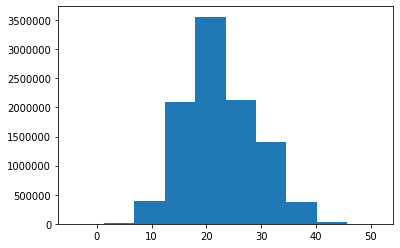

In [55]:
plt.hist(corr_mags)

In [58]:
np.mean(corr_mags < 20.5)

0.428629

### X-ray flux

In [59]:
flux = ((10 ** sim['Lx'].values * (u.erg/u.s)) / 
           (4 * np.pi * (sim['d_kpc'].values*u.kpc)**2)
          ).to(u.erg/u.s/u.cm**2).value

In [60]:
sim['flux_X'] = flux

### optical flux

In [ ]:
sim['flux_opt'] = ((10 ** sim['Lopt'].values * (u.erg/u.s)) / 
           (4 * np.pi * (sim['d_kpc'].values*u.kpc)**2)
          ).to(u.erg/u.s/u.cm**2).value

(array([4.550000e+02, 3.854700e+04, 6.646900e+05, 2.307577e+06,
        2.870615e+06, 3.889236e+06, 2.217600e+05, 6.808000e+03,
        3.020000e+02, 1.000000e+01]),
 array([-13.55386213, -12.40903364, -11.26420515, -10.11937667,
         -8.97454818,  -7.82971969,  -6.68489121,  -5.54006272,
         -4.39523424,  -3.25040575,  -2.10557726]),
 <a list of 10 Patch objects>)

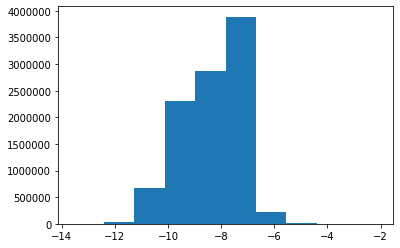

In [166]:
plt.hist(np.log10(flux))

### Correct for extinction

In [91]:
MAXI = pd.DataFrame([(1e-15, 0, 3.354e-8),
(1e-15, 3e19, 3.353e-8),
(1e-15, 3e20, 3.346e-8),
(1e-15, 3e21, 3.276e-8),
(1e-15, 1e22, 3.115e-8),
(1e-15, 2e22, 2.919e-8),
(1e-15, 3e22, 2.756e-8),
(1e-15, 6e22, 2.390e-8),
(1e-15, 1e23, 2.064e-8)
], columns=['flux', 'nH', 'GSC'])

MAXI['attn'] = MAXI['GSC']/ 3.354e-8

In [92]:
class Interpolate():
    """Interpolates webPIMMs counts to get cps as a function of flux and nH"""
    def __init__(self, WP_output):
        self.data = WP_output

        # use 1-d interpolation to fill in the extinction at each column density
        self.attn_interp = interp1d(self.data['nH'], self.data['attn'], kind='quadratic')

    def check_interp(self):
        '''Plot the interpolation from self.cps_interp against the WebPIMMS output'''
        fig, ax = plt.subplots()
        ax.set_xscale("log", nonposx='clip')
        ax.set_yscale("log")
        self.data.plot(x='nH', y='attn', ax=ax)
        xs = np.logspace(19, 23, 100)
        ax.plot(xs, self.attn_interp(xs))
        plt.ylabel('attn')
        plt.show()
        
    def get_corr_flux(self, nH, flux):
        '''Returns the expected counts/s accounting for extinction due to nH'''
        return (self.attn_interp(nH) * flux).astype(float)

In [93]:
test = Interpolate(MAXI)

In [95]:
sim['corr_flux_X'] = test.get_corr_flux(sim['nH'], flux)

In [97]:
sim['log_corr_flux_X'] = np.log10(sim['corr_flux_X'])
sim['corr_mag'] = corr_mags

### Corrected optical flux (r band)

In [99]:
sim['corr_flux_opt'] = ((sim['corr_mag'].values * u.ABmag).to(u.Jy) * (c * 200*u.nm/(650*u.nm)**2)).to(u.erg/u.s/u.cm**2).value

### (spot check that the two distr aren't b/c of different filters)

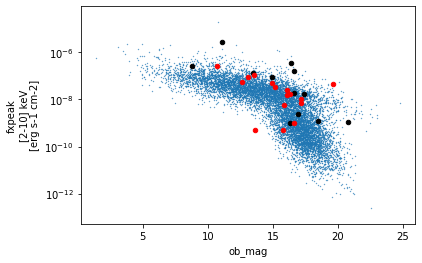

In [73]:
fig, ax = plt.subplots()
# ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log")
sim.sample(n=10000).plot.scatter(x='mag', y='flux_X', s=.1, ax=ax)
data.loc[data['ob_band'] == 'V'].plot.scatter(x='ob_mag', y='fxpeak\n[2-10] keV\n[erg s-1 cm-2]', color='k', ax=ax)
data.loc[~(data['ob_band'] == 'V')].plot.scatter(x='ob_mag', y='fxpeak\n[2-10] keV\n[erg s-1 cm-2]', color='r', ax=ax)

In [134]:
df.query('ob_mag > 19')

,ID,Name \n(Counterpart),RA \n[hh:mm:ss],DEC \n[dd:mm:ss],ℓ\n[deg],b \n[deg],Magnitude\nOutburst (AB),Mag. \nQuies. (AB),d \n[kpc],fxpeak\n[2-10] keV\n[erg s-1 cm-2],...,ob_mag_err,q_band,q_mag,q_mag_err,Name,ob_filter,q_filter,Lx,L_opt,corr_mag
30,38,IGR J17098-3628,17:09:46,-36:27:57,349.553913,2.074516,V∼20.8,NaN,∼10.5,1.080000e-09,...,NaN,NaN,NaN,NaN,IGR J17098-3628,CTIO V,NaN,1.292215e+35,1.237444e+33,13.847
60,8,H 1743-322 \nXTE J1746-322 = IGR J17464-3213,17:46:16,-32:14:01,357.255037,-1.832917,I=19.6,i'>24,∼10,4.620000e-08,...,NaN,NaN,NaN,NaN,H 1743-322,CTIO I,NaN,5.527808e+36,1.560961e+33,12.786


### Get relative sensitivities

In [155]:
# sensitivity of survey
MAXI_sens_full = 5.9e-12 * u.erg/u.s/u.cm**2
MAXI_sens = 10 * 1.21e-11 * u.erg/u.s/u.cm**2 # 10 mC

EP_sens = .1 * MAXI_sens

ZTF_sens = ((20.5 * u.ABmag).to(u.Jy) * (c * 200*u.nm/(650*u.nm)**2)).to(u.erg/u.s/u.cm**2)
LSST_sens = ((24.5 * u.ABmag).to(u.Jy) * (c * 200*u.nm/(650*u.nm)**2)).to(u.erg/u.s/u.cm**2)

In [147]:
relative_sens = MAXI_sens / ZTF_sens

In [148]:
relative_sens

<Quantity 7443.74317572>

In [132]:
MAXI_sens

<Quantity 1.22916667e-10 erg / (cm2 s)>

### Calculate relative fluxes

In [136]:
# relative_flux = sim['corr_flux_X'] / sim['corr_flux_opt']

Text(0.5, 1.0, 'Relative Flux of and Sensitivity to LMXB Outbursts')

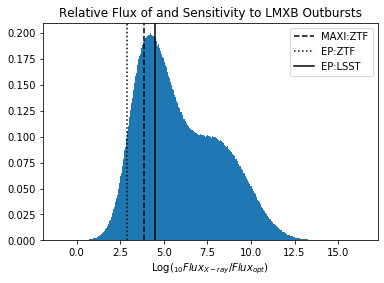

In [149]:
plt.hist(np.log10(relative_flux), density=True, bins='fd')
plt.xlabel(r'Log($_{10}Flux_{X-ray}/Flux_{opt}$)')
plt.axvline(np.log10(relative_sens), color='k', ls='--', label='MAXI:ZTF')
plt.axvline(np.log10(EP_sens / ZTF_sens), color='k', ls=':', label='EP:ZTF')
plt.axvline(np.log10(EP_sens / LSST_sens), color='k', ls='-', label='EP:LSST')

plt.legend()
plt.title('Relative Flux of and Sensitivity to LMXB Outbursts')
# plt.savefig()

67\% of LMXBs first detectable by ZTF than MAXI

In [156]:
(relative_flux < relative_sens).mean()

0.2113095

56\% of LMXBs first detectable by ZTF than Einstein Probe

$1.7\times10^{33}\mathrm{\,ergs\,s^{-1}\,cm^{2}}$

In [157]:

(relative_flux < (EP_sens / ZTF_sens)).mean()

0.0334968

73\% of LMXBs first detectable by ZTF than MAXI

In [159]:
(relative_flux < (EP_sens / LSST_sens)).mean()

0.270073

In [31]:
np.nanmean((Lx / L_opt))

7468.460369332337

# Absolute mags

In [78]:
data['dm'] = 5 * np.log10(data["d"] * 1e3) - 5.0

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
(data['corr_mag'] - data['dm']).mean()

-0.5379971629980788